# Pneunomia detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Step: Reading pictures in

In [2]:

# lehetséges modellek amik jók lehetnek: resnet50(ezzel csináltam a betűfelismerést), sequential(ez vol kaggle-on), svm(ez volt amm órán),

ütemterv:
- Rövid helyzetjelentés emailben (sikerült-e a haladni, mi a helyzet), minden héten kedden (akkor is, ha épp nem volt rá idő vagy energia)
- Április 10-ig: kész és dokumentált feltáró adatelemzés (EDA)
- Április 19-ig: teljes, kész irodalomkutatás - adatbányászat + EDA alapok + gépi tanulás és algoritmusok melyeket használni fogsz
- Május 7-ig: elkészült gépi tanulási modellek és az eredmények értékelése
- Május 13-ig: Benyújtásra kész, általad véglegesnek ítélt dokumentáció elküldése nekem (az osztályzatnál figyelembe lesz véve az állapota)
- Május 24-ig: Az egyetemnek benyújtott dokumentáció (végső értékeléshez)
- Teljesen kész prezentáció a prezentáció előtt egy héttel legalább

In [44]:
'''!pip install tensorflow
!pip install keras
!pip install tqdm
!pip install opencv-python'''

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
import tqdm
import glob

#resnet importalasa
'''from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions'''

'from keras.applications.resnet50 import ResNet50\nfrom keras.applications.resnet50 import preprocess_input, decode_predictions'

In [4]:
#beolvasas
train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]

train_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]

val_pneumonia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]
val_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/val/NORMAL/*.jpeg"), desc = "Betoltes") ]
test_pneumonia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/test/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]
test_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/test/NORMAL/*.jpeg"), desc = "Betoltes") ]

Betoltes: 100%|██████████| 234/234 [00:07<00:00, 31.51it/s]


In [5]:
print(f'{len(train_normal)}')
print(f'{len(train_pneunomia)}')
print(f'{len(val_normal)}')
print(f'{len(val_pneumonia)}')
print(f'{len(test_normal)}')
print(f'{len(test_pneumonia)}')

1341
3895
8
8
234
390


In [6]:
# beolvasas megvaltoztatva
# koncepció: a normal tüdő marad, de a bakterialis és virusosat szetvalasztjuk mindenhol(trainnél értelemszerű okokból, test-nél meg azért hogy tudjunk ellenőrzést csinálni a hatékonyságról)
import os
bacterial_lungs = []
virus_lungs = []

fajlok = glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg")

for file in tqdm.tqdm(fajlok, desc="Betöltés"):
    fajlnev = os.path.basename(file).lower()  # kisbetűs összehasonlítás miatt
    if "bacteria" in fajlnev:
        bacterial_lungs.append(cv2.imread(file))
    elif "virus" in fajlnev:
        virus_lungs.append(cv2.imread(file))

print(f"\nBacteria képek: {len(bacterial_lungs)}")
print(f"Virus képek: {len(virus_lungs)}")

Betöltés: 100%|██████████| 3895/3895 [01:16<00:00, 50.68it/s]


Bacteria képek: 2544
Virus képek: 1351


# Feltáró adatelemzés (Exploratory Data Analysis)

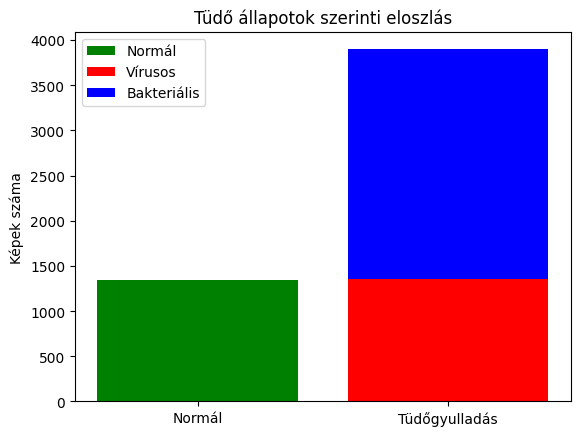

In [7]:
# class imbalance:
virus_count = len(virus_lungs)
bacteria_count = len(bacterial_lungs)
normal_count = len(train_normal)

# X-tengely címkék
x = ['Normál', 'Tüdőgyulladás']

# A stackelt oszlop részei
pneumonia_total = virus_count + bacteria_count

# Oszlopok elhelyezése
x_pos = [0, 1]

# Rajzolás
plt.bar(x_pos[0], normal_count, color='green', label='Normál')
plt.bar(x_pos[1], virus_count, color='red', label='Vírusos')
plt.bar(x_pos[1], bacteria_count, bottom=virus_count, color='blue', label='Bakteriális')

# Tengely beállítás
plt.xticks(x_pos, x)
plt.ylabel('Képek száma')
plt.title('Tüdő állapotok szerinti eloszlás')
plt.legend()
#plt.tight_layout()
plt.show()

Konklúzió: Látható, hogy fetőzött tüdőről lényegesen több kép van mint normálisról, ezáltal előfordulhat egyenlőtlenség

In [8]:
# checking the image sizes
def get_dimensions(dataset):
    dimensions = pd.DataFrame(columns=['height', 'width'])
    for i in range(0, len(dataset)):
        im = dataset[i]
        array = np.array(im)
        h,w,d = array.shape
        dimensions.loc[len(dimensions)] = [h,w]
    return dimensions

In [9]:
normal_df = get_dimensions(train_normal)

<Axes: title={'center': 'Képek felbontásának megoszlása normál tüdőknél'}, xlabel='Szélesség', ylabel='Magasság'>

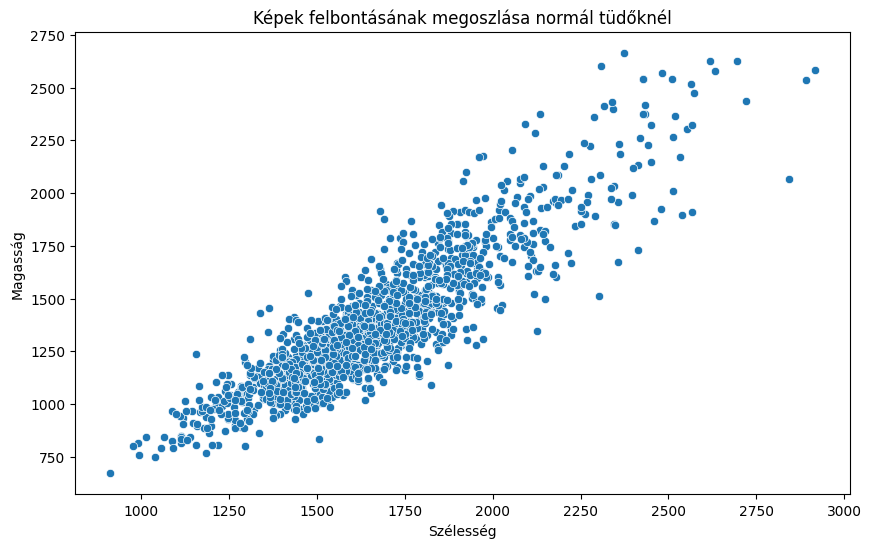

In [10]:
# plotting image sizes
plt.figure(figsize=(10,6))
plt.title('Képek felbontásának megoszlása normál tüdőknél')
plt.xlabel('Szélesség')
plt.ylabel('Magasság')
sns.scatterplot(data=normal_df, x='width', y='height')

In [11]:
pneumonia_df = get_dimensions(train_pneunomia)

<Axes: title={'center': 'Képek felbontásának megoszlása feertőzött tüdőknél'}, xlabel='Szélesség', ylabel='Magasság'>

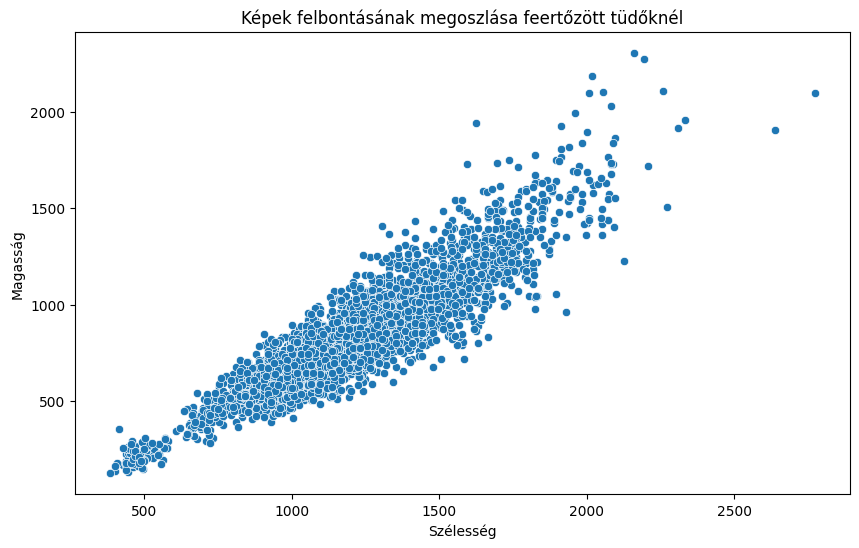

In [12]:
plt.figure(figsize=(10,6))
plt.title('Képek felbontásának megoszlása feertőzött tüdőknél')
plt.xlabel('Szélesség')
plt.ylabel('Magasság')
sns.scatterplot(data=pneumonia_df, x='width', y='height')

Konklúzió: A képek egyáltalán nem egységesek, nagyon sokféle méretben vannak jelen az adatbázisban

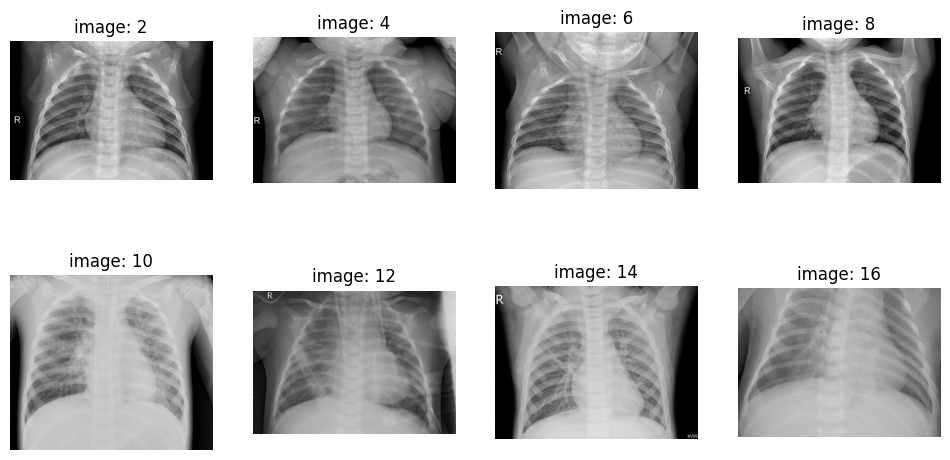

In [13]:
# Showing examples from each class
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i) #sor,oszlop,melyiknel legyen epp
    if i < 5:
        plt.imshow(train_normal[i*2])
        plt.title(f"image: {i*2}")
        plt.axis('off')
    else:
        plt.imshow(train_pneunomia[i*2])
        plt.axis('off')
        plt.title(f"image: {i*2}")


In [14]:
#resizing the images for faster calculations with keeping the aspect ratio nem is fix hogy kell
'''def resize_with_keeping_ratio(images):
    resized_images = []
    for image in images:
        # Get the original dimensions
        (h, w) = image.shape[:2]

        # Desired width
        new_width = 256

        # Calculate the aspect ratio
        aspect_ratio = h / w
        new_height = int(new_width * aspect_ratio)

        # Resize the image
        resized_image = cv2.resize(image, (new_width, new_height))
        resized_images.append(resized_image)
    return resized_images'''
#hatekonyabb
def resize_with_keeping_ratio(images, new_width=256):
    return [cv2.resize(img, (new_width, int(new_width * img.shape[0] / img.shape[1]))) for img in images]

In [15]:
resized_normal = resize_with_keeping_ratio(train_normal)
resized_pneumonia = resize_with_keeping_ratio(train_pneunomia)

In [17]:
# Images as matrix
from tensorflow.keras.preprocessing import image
img = image.img_to_array(resized_normal[0])

In [18]:
import os
def img2np(path, list_of_filename, size=(64, 64)):
    full_mat = []  # Üres lista kezdetben

    for fn in list_of_filename:
        fp = os.path.join(path, fn)  # Helyes fájlelőérési útvonal
        current_image = image.load_img(fp, target_size=size, color_mode='grayscale')
        img_ts = image.img_to_array(current_image).ravel()  # 1D tömb

        full_mat.append(img_ts)  # Hozzáadjuk a listához

    return np.array(full_mat, dtype=np.float32)  # NumPy tömbbé alakítás

In [19]:
list_of_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/")
normal_array = img2np("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/",list_of_files)
#Ide azért majd kéne egy kis magyarázat, jelenleg fogalmam sincs mit csinál
#pneumonia_array = img_to_np(resized_pneumonia)

In [20]:
# how does the average image looks like
def mean_img(matrix_array, title, img_size=(64, 64)):
    matrix_array = np.array(matrix_array)  # Biztosítjuk, hogy NumPy tömb
    mean = np.mean(matrix_array, axis=0)  # Átlagolás a képek dimenziója mentén
    mean = mean.reshape(img_size)  # Visszaalakítás 2D formába

    plt.imshow(mean, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Átlagos {title}')
    plt.axis('off')
    plt.show()

    return mean

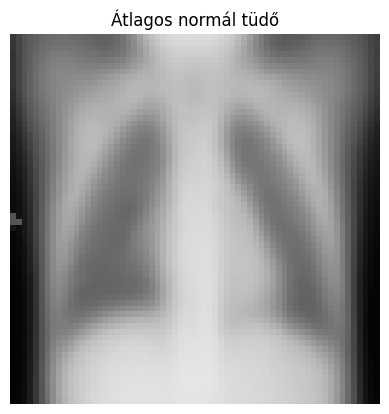

In [21]:
ANL = mean_img(normal_array,"normál tüdő") # ANL = Average Normal Lung

In [22]:
list_of_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/")
normal_array = img2np("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/",list_of_files)

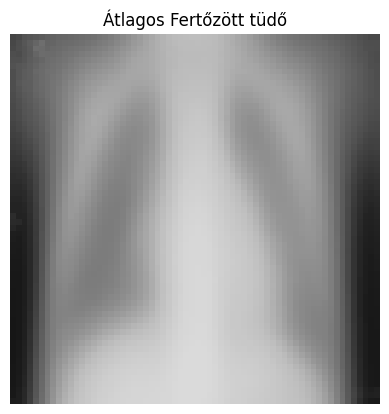

In [23]:
APL = mean_img(normal_array,"Fertőzött tüdő") # APL = Average Pneumonia Lung

Konklúzió: Látható hogy a fertőzött tüdőknél jobban elhomályosodik a mellkasi rész

Megnézzük a különbséget is a normál és a fertőzött tüdő között

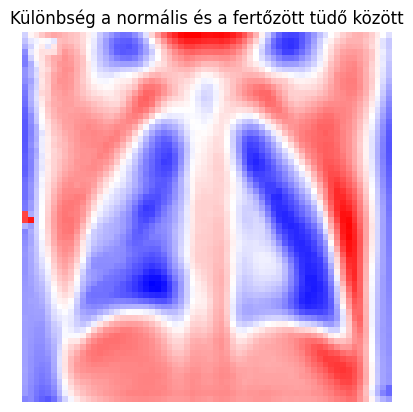

In [28]:
contrast_mean = ANL - APL
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Különbség a normális és a fertőzött tüdő között')
plt.axis('off')
plt.show()
#ez most mit jelent?

Feltáró adatelemzés lezárása, konklúziók összesítése, dokumentálás stb stb.

# Adat augmentáció elkészítése a normál halmazhoz

In [25]:
# valtozok: train_normal a normal kepek
# resized normal: aranyosan ujrameretezett kepek
# mivel a tanulo modellnek szabvany meret kell ezert a resized normalt lehet el is fogom dobni

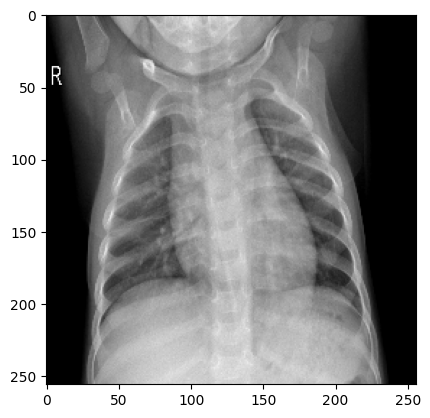

In [50]:
# kb 3x annyi kép kell mint jelenleg van. terv: a harmadat elforgatom 90 fokkal jobbra a harmadat ugyanigy balra az utolso harmadot fejjel lefele forgatom meg
#nem lehet imgaugot hasznalni az uj numpyal
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
resize_and_rescale = keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255) # minden pixel erteket atrak 0-255 ről 0-1 re
])
img = train_normal[0]
resized_img = resize_and_rescale(img)
plt.imshow(resized_img)
# jo tehat eddig mukodik

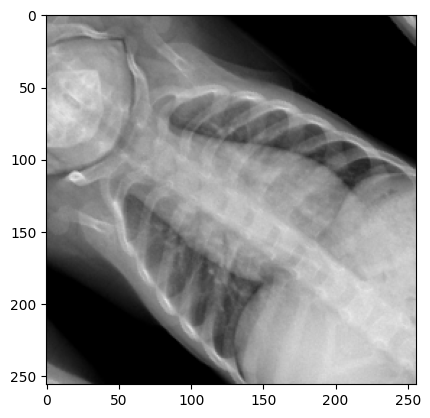

In [99]:
def augmentation(images):
  data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
  ])
  for i in images:
    augmented_img = data_augmentation(i)
    images.append(augmented_img)
  return images



In [101]:
type(train_normal)

list